# Programming Language DataBase (PLDB) Visualization

In [74]:
import requests
import networkx as nx
from bs4 import BeautifulSoup
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from tqdm import tqdm
from src.process_text import clean_text

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
tqdm.pandas()

## Load and preprocess

We obtained the data from the PLDB database. The dataset contains information such as the programming language name, year of appearance, type, rank, fact count, last activity, example count, book count, and more. Before constructing the network, we first clean the data and prepare it for analysis.

In [9]:
pldb_raw = pd.read_csv("./data/pldb.csv")
pldb_raw.head()

/home/fyy/miniconda3/envs/modern_nlp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (15,16,17,25,30,38,41,44,46,47,48,49,50,51,52,53,56,59,60,61,63,69,71,72,73,75,76,78,79,80,81,82,83,84,85,87,89,91,92,93,94,95,96,97,98,99,100,101,103,104,110,111,112,113,114,115,116,117,119,121,122,123,126,128,129,130,131,132,133,134,135,137,138,142,143,144,145,146,147,148,150,151,156,157,158,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,183,184,185,186,187,188,189,190,191,192,194,195,196,197,198,200,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310

,title,appeared,type,pldbId,rank,languageRank,factCount,lastActivity,exampleCount,bookCount,...,features.hasIds,ebook,features.hasExports,features.hasZippers,features.hasMonads,extensionOf,zulip,features.hasImplicitArguments,features.hasDynamicTyping,features.hasMethodChaining
0,Java,1995,pl,java,0,0.0,920,2022,20,401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JavaScript,1995,pl,javascript,1,1.0,818,2022,54,351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
2,C,1972,pl,c,2,2.0,426,2022,26,78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Python,1991,pl,python,3,3.0,691,2022,35,342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SQL,1974,queryLanguage,sql,4,4.0,324,2022,6,182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
SELECTED_COLUMNS = [
    "title", "appeared", "type", "rank", "factCount", "lastActivity",
    "exampleCount", "bookCount", "paperCount", "numberOfUsers", "numberOfJobs",
    "originCommunity", "country", "wikipedia.summary", "wikipedia.related"
]

In [12]:
pldb_raw = pldb_raw[SELECTED_COLUMNS]
pldb_raw.head()

,title,appeared,type,rank,factCount,lastActivity,exampleCount,bookCount,paperCount,numberOfUsers,numberOfJobs,originCommunity,country,wikipedia.summary,wikipedia.related
0,Java,1995,pl,0,920,2022,20,401,37,5550123,85206,Sun Microsystems,United States,Java is a general-purpose computer programming...,javascript pizza ada csharp eiffel mesa modula...
1,JavaScript,1995,pl,1,818,2022,54,351,48,5962666,63993,Netscape,United States,"JavaScript (), often abbreviated as JS, is a h...",java lua scheme perl self c python awk hyperta...
2,C,1972,pl,2,426,2022,26,78,19,3793768,59919,Bell Labs,United States,"C (, as in the letter c) is a general-purpose,...",cyclone unified-parallel-c split-c cilk b bcpl...
3,Python,1991,pl,3,691,2022,35,342,52,2818037,46976,Centrum Wiskunde & Informatica,Netherlands,Python is a widely used high-level programming...,jython micropython stackless-python cython abc...
4,SQL,1974,queryLanguage,4,324,2022,6,182,37,7179119,219617,IBM,United States,SQL ( ( listen) ESS-kew-EL or ( listen) SEE-k...,sql-92 datalog linq powershell c sql-psm sqlpl...


In [14]:
print(
    "Percentage of NaN values in the PLDB dataset (total {} rows):".format(len(pldb_raw))
)
print((pldb_raw.isna().sum() / len(pldb_raw) * 100).sort_values()[:20])

Percentage of NaN values in the PLDB dataset (total 4818 rows):
title                 0.000000
appeared              0.000000
type                  0.000000
rank                  0.000000
factCount             0.000000
lastActivity          0.000000
exampleCount          0.000000
bookCount             0.000000
paperCount            0.000000
numberOfUsers         0.000000
numberOfJobs          0.000000
originCommunity      27.791615
country              32.004981
wikipedia.summary    66.417601
wikipedia.related    73.204649
dtype: float64


There are 4 columns with too many null values. We need to replace them.

In [15]:
pldb = pldb_raw.fillna({
    "originCommunity": "Unknown",
    "country": "Unknown",
    "wikipedia.summary": "",
    "wikipedia.related": "",
})

## First Glimpse

### Network indicating relations between different programming languages

To construct the network, we first treated programming languages with the same type as similar languages. We then added an edge between two languages if they share the same type. Before constructing the network, we first take a look at the distribution of types. We found that there are several different types of programming languages in the dataset, including general-purpose, web, and database. To visualize the distribution of different types, we created a simple bar plot that shows the number of programming languages for each type, in descending order.

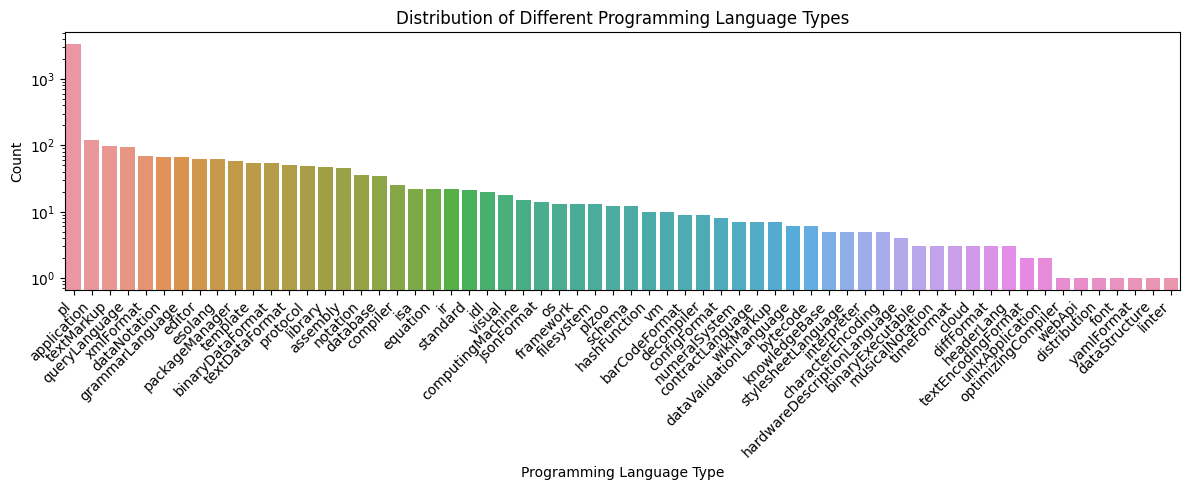

In [55]:
# Set figure size
plt.figure(figsize=(12, 5))

# Count the frequency of each type
type_counts = pldb['type'].value_counts()

# Plot the bar plot using seaborn
sns.barplot(x=type_counts.index, y=type_counts.values)

# Add labels and title
plt.xlabel("Programming Language Type")
plt.ylabel("Count")
plt.title("Distribution of Different Programming Language Types")

# Rotate the x-axis labels by 45 degrees
plt.xticks(ha="right", rotation=45)

# Set the y-axis scale to log
plt.yscale('log')

# Tight Layout
plt.tight_layout()

# Show the plot
plt.show()

From above, we could see the type has a skewed distribution. Most of the languages have the type "pl". So if we use simply use `type` as the similarity metric, we could see several seperated cliques with a large cluster in the middle (pl language).

Now let's create the network. For simplicity, we just show the top 100 programming languages. The resulting network shows the relationship between different programming languages, with nodes representing the programming languages and edges indicating the similarity between them.

In [71]:
pldb_100 = pldb.iloc[:100]

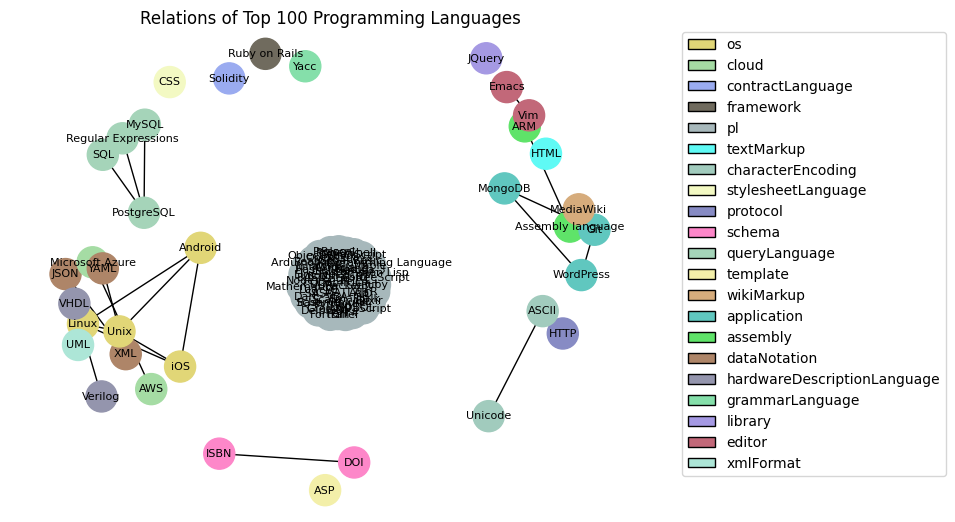

In [46]:
# Create a NetworkX graph
G = nx.Graph()

# Add nodes to the graph
for index, row in pldb_100.iterrows():
    G.add_node(row["title"], type=row["type"])

# Connect nodes with the same type
for i, row1 in pldb_100.iterrows():
    for j, row2 in pldb_100.iterrows():
        if i >= j:
            continue
        if row1["type"] == row2["type"]:
            G.add_edge(row1["title"], row2["title"])

# Draw the graph
pos = nx.spring_layout(G, k=0.5)

# Assign a random color to each node type
node_types = list(set([node[1]["type"] for node in G.nodes(data=True)]))
node_colors = {}
for node_type in node_types:
    node_colors[node_type] = [random.uniform(0.35, 1), random.uniform(0.35, 1), random.uniform(0.35, 1)]

node_colors_list = [node_colors[node[1]["type"]] for node in G.nodes(data=True)]
nx.draw(G, pos, with_labels=False, node_size=500, node_color=node_colors_list)

# Add node labels
labels = {node[0]: node[0] for node in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

# Add a legend
legend_handles = []
for node_type, color in node_colors.items():
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, fc=color, edgecolor='black'))
plt.legend(legend_handles, node_colors.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.title("Relations of Top 100 Programming Languages")

plt.show()

We could see the resulting network has a large central cluster of "pl" languages and several smaller separated clusters.

### Word Cloud for each programming language

Another thing we want to do is to show the wordcloud for each programming language.

Before visualizing the data, we cleaned the text by removing stopwords, numbers, and punctuations.

In [72]:
pd.options.mode.chained_assignment = None
pldb_100["wikipedia.summary"] = pldb_100["wikipedia.summary"].apply(clean_text)

For simplicity, we select top 10 programming language and show their wordclouds.

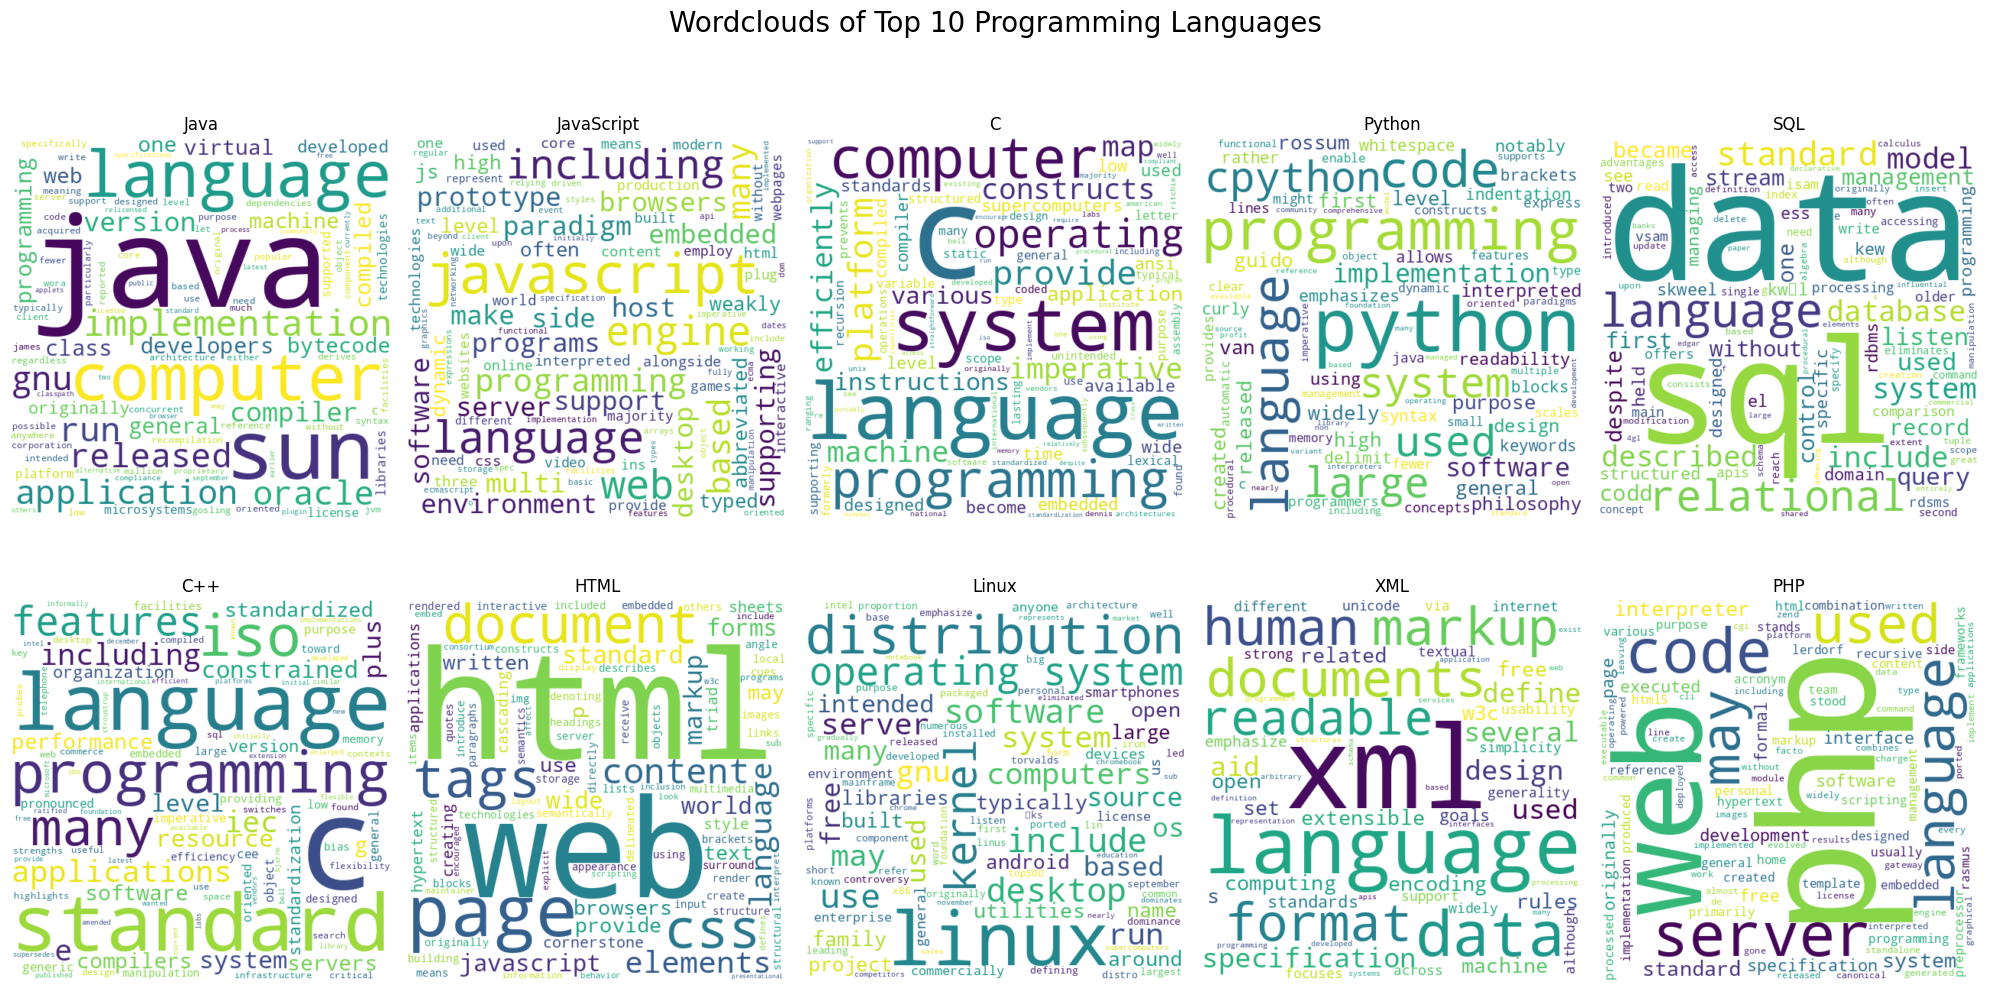

In [76]:
# Sample 10 from 100
pldb_10 = pldb_100.iloc[:10]

# Set up subplot grid
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()

# Generate wordclouds for top 10 languages
for i, language in enumerate(pldb_10["title"]):
    text = pldb_10[pldb_10["title"] == language]["wikipedia.summary"].values[0]
    wc = WordCloud(width=500, height=500, max_words=100, background_color='white').generate(text)
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].set_title(language)
    axs[i].axis('off')

plt.tight_layout()
plt.suptitle("Wordclouds of Top 10 Programming Languages", fontsize=20, y=1.05)
plt.show()

The word cloud visualizations show the most frequent words in the summary of each programming language. The most common words, including the name and key features, provide insight into the defining characteristics of each language.